# Editing ArcGIS Online Data

Editing data in ArcGIS Online is a very in-demand process as more workflows are moving to the cloud.  While ArcGIS Online makes it much easier for multiple users to edit the same dataset by hand, it presents some problems for automation.  With desktop GIS and local datasets, you have pretty easy access to the table data via databases or shapefiles.  With ArcGIS Online, you only have access to the server.  This means that rather than directly edit the data, you have to interact with the server through the following steps:
 - query the target dataset creating a copy
 - modify your copy of the dataset
 - communicate your changes back to the server
 
Let's suppose (for an example) that we have a project where we're collecting field data.  In this case, we'll use some dummy vegetation data.  Our field users want a useful way to identify their points and communicate to each other once they've collected their data.
 
In desktop programs and databases, ArcGIS provides a special kind of field called an "Auto-Incrementing ID" field.  This helps end users communicate which feature they're talking about in a very human-friendly way.

In [ ]:
# input your specific username
username = input('Username: ')

import arcgis

# set up a GIS object to store your login information and acccess our data.
session_gis = arcgis.GIS('https://arcgis.com',username)

<Item title:"Demo_Vegetation_Data_Base" type:Feature Layer Collection owner:dancranford>
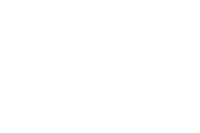

In [2]:
# item containing our vegetation data to edit
item_to_edit = arcgis.gis.Item(session_gis, '11f10170934c413c8db8a40563ed9a4a')
item_to_edit

In [4]:
# let's look for a point layer
all_layers = item_to_edit.layers

for i, layer in enumerate(all_layers):
    print(i, layer.properties.name)

0 Point layer
1 Polygon layer


In [5]:
# We'll be focusing on the point layer for the time being.
lyr_points = all_layers[0]